In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import torch
from rpasim.ode import AB
from rpasim.plot.ode import plot_trajectory
from rpasim.plot.env import plot_env_trajectory
from rpasim.env import DifferentiableEnv
import matplotlib.pyplot as plt

from rpasim.style import set_style
set_style()

# Test AB ODE

Equations:
- dA/dt = alpha1 + alpha2*A + alpha3*B
- dB/dt = beta1*A - beta2**B

In [30]:
# Create AB ODE instance
differentiable_params = torch.tensor([1, 0, -1/4], requires_grad=True)  # [alpha1, alpha2, alpha3]
fixed_params = torch.tensor([10, 1])  # [beta1, beta2]

ab_ode = AB(differentiable_params=differentiable_params, fixed_params=fixed_params)

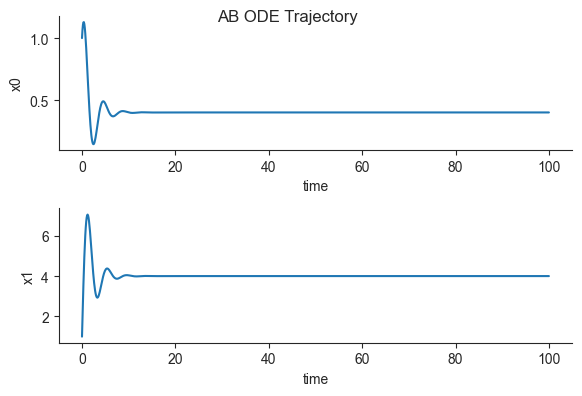

In [31]:
# Set initial state and time
x0 = torch.tensor([1.0, 1])  # [A, B]
T = 100.0

# Plot trajectory
fig, axes = plot_trajectory(ab_ode, x0, T, n_steps=1000)
fig.suptitle('AB ODE Trajectory')
plt.show()

# Test DifferentiableEnv

Now test the same ODE in the differentiable environment

Reward: -5.11
Reward: -2.01
Reward: -1.82
Reward: -1.54
Reward: -1.16
Reward: -0.71
Reward: -0.20
Reward: -0.36
Reward: -0.94
Reward: -3.52
Reward: -2.05
Reward: -2.15
Reward: -2.28
Reward: -2.43
Reward: -2.60
Reward: -2.77
Reward: -2.91
Reward: -3.01
Reward: -6.05
Reward: -3.00
Reward: -2.98
Reward: -2.94
Reward: -2.88
Reward: -2.79
Reward: -2.66
Reward: -2.48
Reward: -2.26
Reward: -3.64
Reward: -1.63
Reward: -1.56
Reward: -1.46
Reward: -1.32
Reward: -1.14
Reward: -0.93
Reward: -0.69
Reward: -0.42
Reward: -0.26
Reward: -0.14
Reward: -0.19
Reward: -0.27
Reward: -0.37
Reward: -0.48
Reward: -0.60
Reward: -0.73
Reward: -0.85
Reward: -1.97
Reward: -1.03
Reward: -1.04
Reward: -1.05
Reward: -1.06
Reward: -1.07
Reward: -1.07
Reward: -1.05
Reward: -1.01
Reward: -1.83
Reward: -0.87
Reward: -0.85
Reward: -0.82
Reward: -0.78
Reward: -0.72
Reward: -0.65
Reward: -0.57
Reward: -0.47
Reward: -0.60
Reward: -0.24
Reward: -0.21
Reward: -0.18
Reward: -0.13
Reward: -0.08
Reward: -0.01
Reward: -0.05
Reward

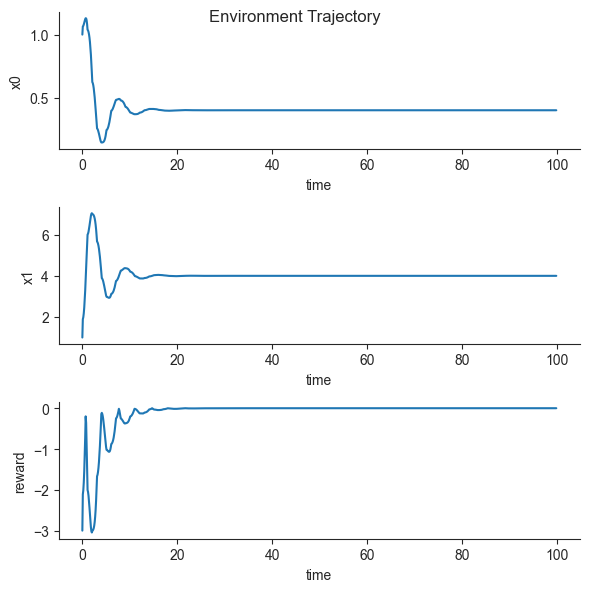

In [33]:
# Create environment
def reward_fn(state):
    # Reward: negative distance from 4
    return -torch.norm(state[-1] - 4).item()

env = DifferentiableEnv(
    initial_ode=ab_ode,
    reward_fn=reward_fn,
    initial_state=x0,
    time_horizon=T,
    n_reward_steps=1000
)

# Reset and run environment
obs, info = env.reset()
total_reward = 0

# Take a few steps
n_steps = 900
for _ in range(n_steps):
    # Action: (same ODE, time_delta)
    action = (ab_ode, T/n_steps)
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    print(f"Reward: {reward:.2f}")

print(f"Total reward: {total_reward:.2f}")
print(len(env.get_trajectory()[0]), "states in trajectory")
print(len(env.get_trajectory()[-1]), "rewards in trajectory")

# Plot environment trajectory
fig, axes = plot_env_trajectory(env)
fig.suptitle('Environment Trajectory')
plt.show()